<font size="7"> Catching Joe's Exploratory Data Analysis </font>

In [1]:
import pandas as pd
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt

Our first problem with this dataset is to normalize the data.  Each sesion is an object but inside "sites" there is a list, to
avoid reading this as a list of dicts, should we expand each site into a row so it can help us by using this information during the model training.

In [2]:
with open('C:/Users/Valentin Villanueva/Downloads/usersessions/dataset.json', 'r') as f:
    data = json.load(f)

In [3]:
df = pd.json_normalize(
    data, 
    record_path=['sites'], 
    meta=['browser', 'os', 'locale', 'user_id', 'gender', 'location', 'time', 'date'])

In [4]:
df.head(5)

,site,length,browser,os,locale,user_id,gender,location,time,date
0,mail.google.com,50,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,09:03:00,2017-01-08
1,toptal.com,132,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,09:03:00,2017-01-08
2,slack.com,65,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,09:03:00,2017-01-08
3,lenta.ru,59,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,09:03:00,2017-01-08
4,youtube.com,67,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,09:03:00,2017-01-08


We are going to keep two datasets, one is "df" with its sites per user session expanded and the other one "my_data" which for each session, the
"sites_str" has every site that the user has visited during the session. This will help us for the exploratory analysis

In [5]:
my_data = pd.DataFrame(data)
### feature eng for EDA
## we want to keep the lenght information for each visit so we create some metrics :
my_data['total_duration'] = my_data['sites'].apply(lambda x: sum(s['length'] for s in x))
my_data['mean_duration']  = my_data['sites'].apply(lambda x: sum(s['length'] for s in x) / len(x) if len(x) > 0 else 0)
my_data['max_duration']   = my_data['sites'].apply(lambda x: max(s['length'] for s in x) if len(x) > 0 else 0)
my_data['num_sites'] = my_data['sites'].apply(lambda x: len(x))
my_data['sites_str'] = my_data['sites'].apply(lambda x: " ".join([s['site'] for s in x]))
my_data.drop('sites', axis=1, inplace=True)
my_data

,browser,os,locale,user_id,gender,location,time,date,total_duration,mean_duration,max_duration,num_sites,sites_str
0,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,09:03:00,2017-01-08,481,80.166667,132,6,mail.google.com toptal.com slack.com lenta.ru ...
1,Firefox,Windows 8,pl-PL,11,m,USA/Chicago,13:57:00,2016-10-05,1076,119.555556,269,9,meduza.org disqus.com youtube.com wikipedia.or...
2,Chrome,Ubuntu,zh-CN,17,m,Singapore/Singapore,02:06:00,2017-03-28,1280,182.857143,376,7,facebook.net live.com youtube.com baidu.com di...
3,Chrome,Windows 10,pt-BR,134,f,Australia/Sydney,21:49:00,2017-06-25,1323,147.000000,301,9,verisign.com booking.com openclassrooms.com sl...
4,Firefox,Windows 10,en-SG,92,f,USA/Chicago,00:05:00,2016-02-10,224,112.000000,145,2,live.com livraddict.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,Chrome,Windows 10,pt-PT,178,m,New Zealand/Auckland,06:02:00,2016-12-30,509,101.800000,202,5,vk.com slack.com youtube.com dartfish.tv issuu...
79996,Safari,MacOS,it-IT,32,m,Netherlands/Amsterdam,10:27:00,2017-01-27,267,66.750000,80,4,slack.com youtube.com vk.com mmhp.net
79997,Firefox,Ubuntu,ru_RU,0,m,USA/Chicago,17:55:00,2017-03-13,698,116.333333,276,6,vk.com slack.com mail.google.com plexop.net ga...
79998,Firefox,Windows 10,ru_RU,56,m,France/Paris,14:17:00,2016-12-06,696,139.200000,251,5,lenta.ru toptal.com vk.com mail.google.com you...


Keeping both datasets will help us in different ways during the Analysis

<font size="6"> Global users EDA </font>

In [6]:
my_data.isnull().sum()

browser           0
os                0
locale            0
user_id           0
gender            0
location          0
time              0
date              0
total_duration    0
mean_duration     0
max_duration      0
num_sites         0
sites_str         0
dtype: int64

There are no missing values in "my_data"

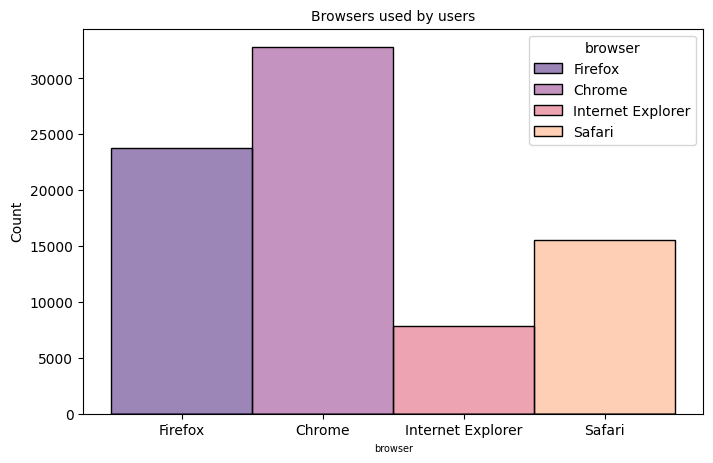

In [7]:
#my_data.browser.unique()
plt.figure(figsize=(8, 5))
sns.histplot(data = my_data, x= "browser" , hue ="browser", palette="magma")
plt.title('Browsers used by users', fontsize=10)
plt.xlabel('browser', fontsize=7)
plt.show()

Observation: It can be seen that "Chrome" is the most visited site used by users

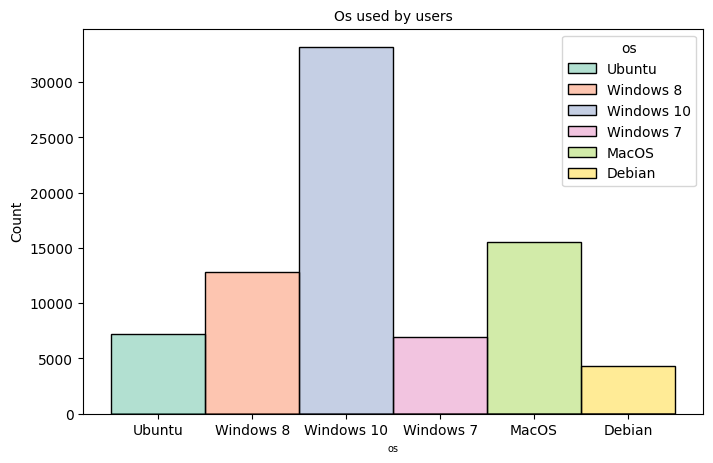

In [8]:
plt.figure(figsize=(8, 5))
sns.histplot(data = my_data, x= "os" , hue="os", palette="Set2")
plt.title('Os used by users', fontsize=10)
plt.xlabel('os', fontsize=7)
plt.show()

Observation: Windows 10 is clearly the most used os between the users.

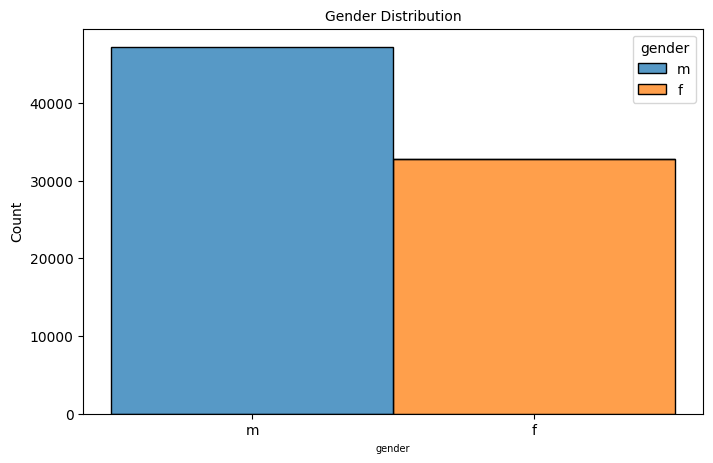

In [9]:
plt.figure(figsize=(8, 5))
sns.histplot(data = my_data, x= "gender" , hue ="gender",multiple="stack" )
plt.title('Gender Distribution', fontsize=10)
plt.xlabel('gender', fontsize=7)
plt.show()

There is no big difference between the amount of male and female  users.

In [10]:
my_data.locale.nunique()

25

There are 25 different languages configurations

C:\Users\Valentin Villanueva\AppData\Local\Temp\ipykernel_22896\4032093817.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Languages', bbox_to_anchor=(1.05, 1), loc='upper left')


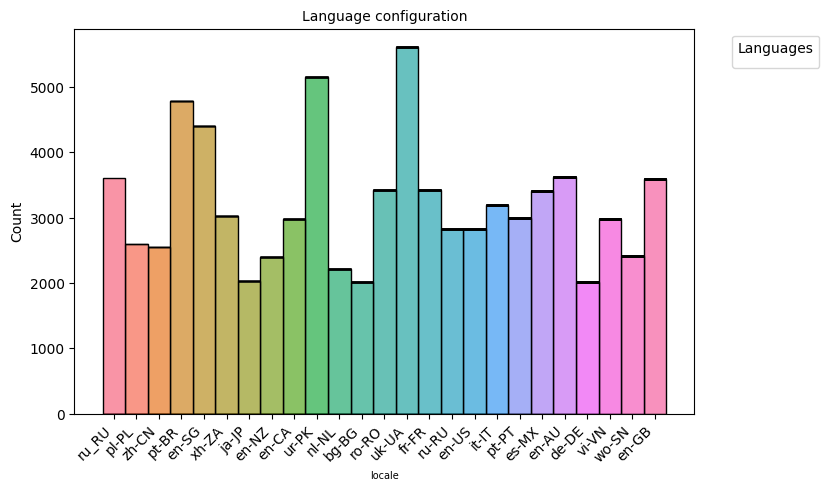

In [11]:
plt.figure(figsize=(8, 5))
sns.histplot(data = my_data, x= "locale" , hue ="locale",multiple="stack" )
plt.title('Language configuration', fontsize=10)
plt.legend(title='Languages', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.xlabel('locale', fontsize=7)
plt.show()

C:\Users\Valentin Villanueva\AppData\Local\Temp\ipykernel_22896\66850682.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')


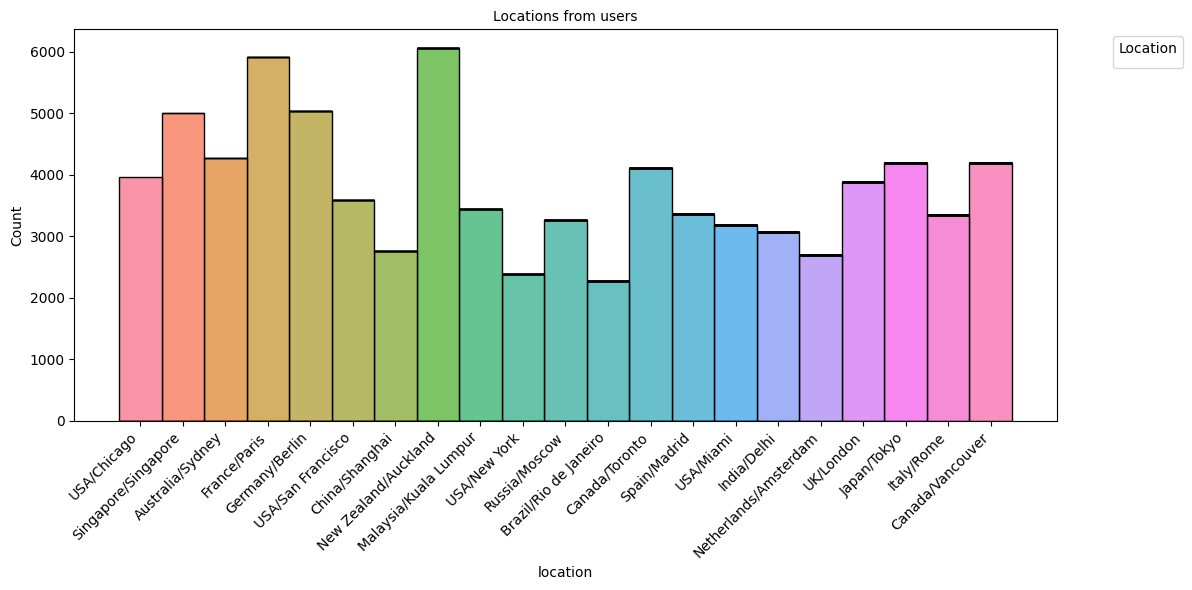

In [12]:
### LOCATIONS AND SESSIOS
#my_data.location.unique()
plt.figure(figsize=(12, 6)) 
sns.histplot(data=my_data, x="location", hue="location", multiple="stack")
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Locations from users', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.show()

Obbservation: Most users locations are from Malaysia and Australia

In [13]:
my_data.user_id.nunique()

200

There are 200 different users.

In [14]:
user_counts = my_data['user_id'].value_counts().sort_values(ascending=False)
user_counts.unique()

array([400])

There are 400 sessions per user.

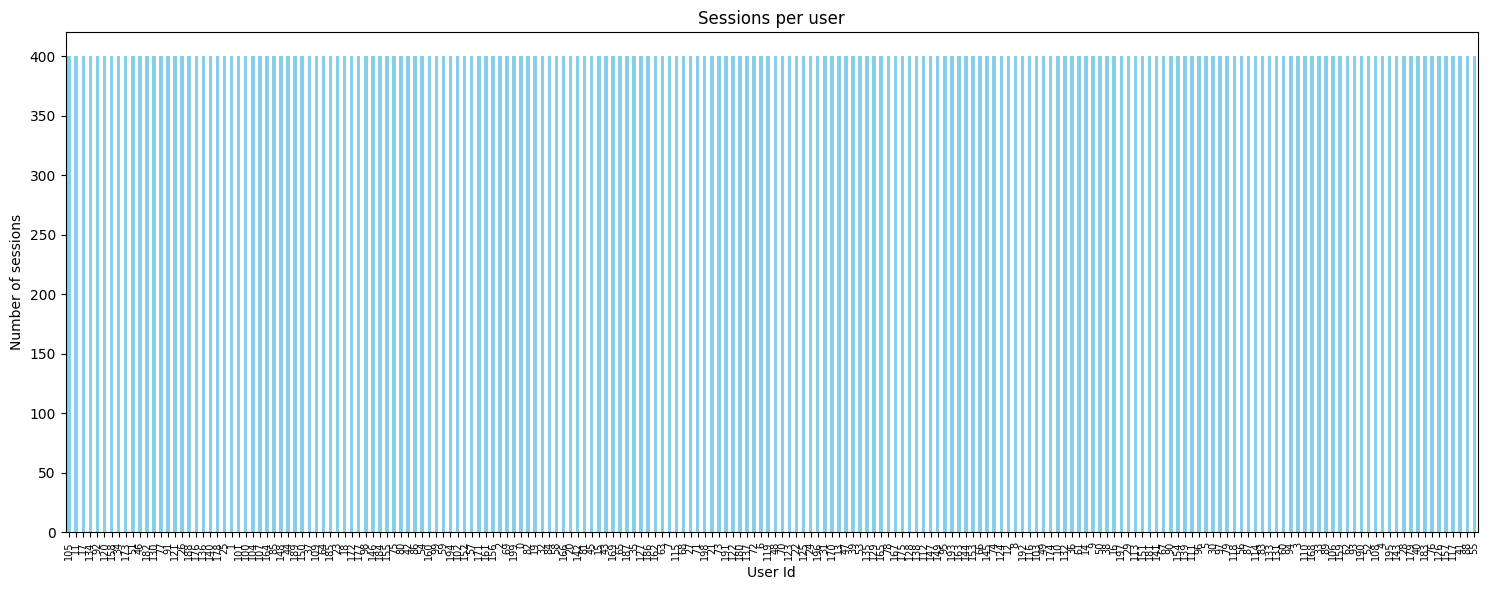

In [15]:
plt.figure(figsize=(15, 6))
user_counts.plot(kind='bar', color='skyblue')
plt.title('Sessions per user')
plt.xlabel('User Id')
plt.ylabel('Number of sessions')
plt.xticks(rotation=90, fontsize=7)
plt.tight_layout()

<font size="5"> Let's have a look at other variables and try to look for outliers or more information. </font>

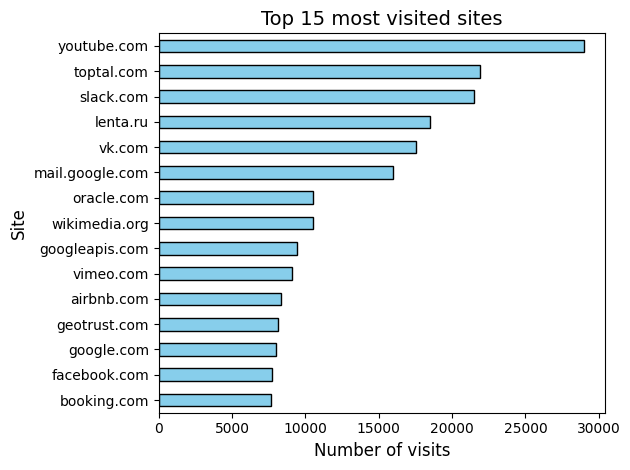

In [16]:
top_sites_global = df.site.value_counts().head(15)
ax = top_sites_global.sort_values().plot(kind='barh', color='skyblue', edgecolor='black')
ax.set_title('Top 15 most visited sites', fontsize=14)
ax.set_xlabel('Number of visits', fontsize=12)
ax.set_ylabel('Site', fontsize=12)
plt.tight_layout()

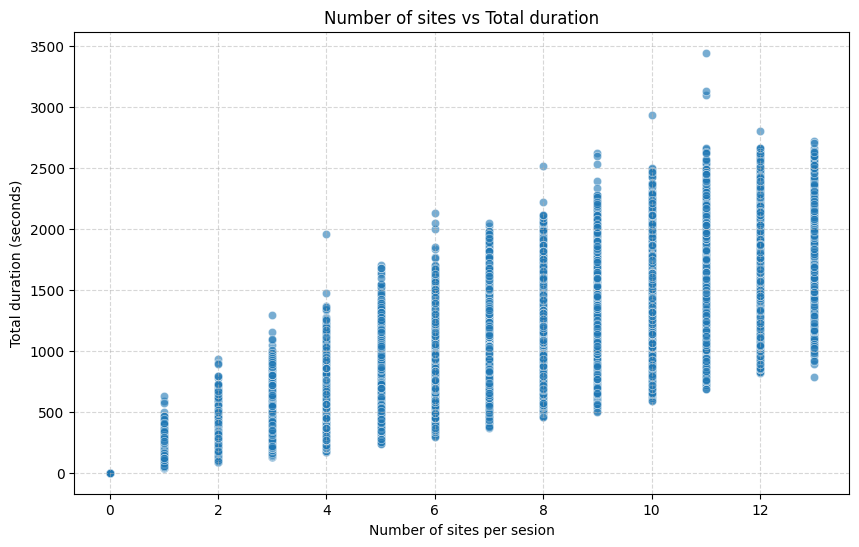

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=my_data, x='num_sites', y='total_duration',alpha=0.6) 
plt.title('Number of sites vs Total duration')
plt.xlabel('Number of sites per sesion')
plt.ylabel('Total duration (seconds)')
plt.grid(True, linestyle='--', alpha=0.5)

<font size="5"> Joe vs All users </font>

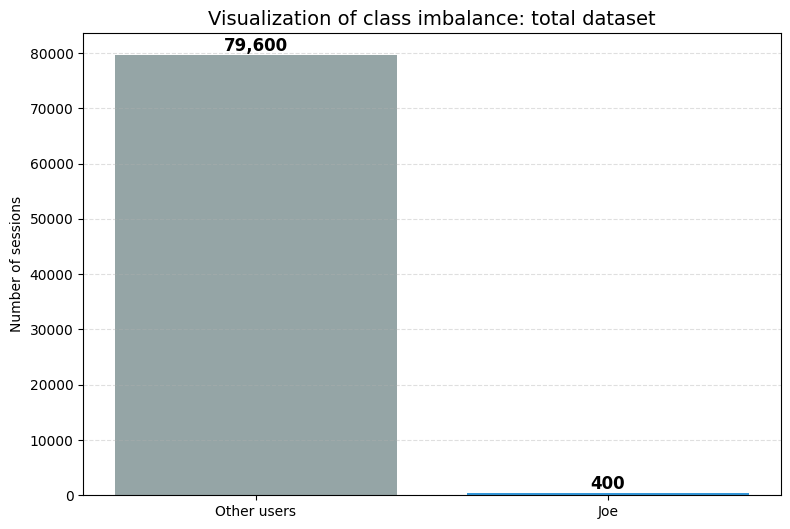

In [18]:
# Joe data points vs all users ( this analysis will be done with the dataframe with all sites compressed)
joe_id = 0 
my_data['class'] = my_data['user_id'].apply(lambda x: 'Joe' if x == joe_id else 'Other users')
class_count = my_data['class'].value_counts().to_frame(name='total_sessions')

plt.figure(figsize=(9, 6))
colors = ['#95a5a6', '#3498db'] 
bars = plt.bar(class_count.index, class_count['total_sessions'], color=colors)
plt.title('Visualization of class imbalance: total dataset', fontsize=14)
plt.ylabel('Number of sessions')
plt.grid(axis='y', linestyle='--', alpha=0.4)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(yval):,}', 
             ha='center', va='bottom', fontweight='bold', fontsize=12)
    
plt.show()

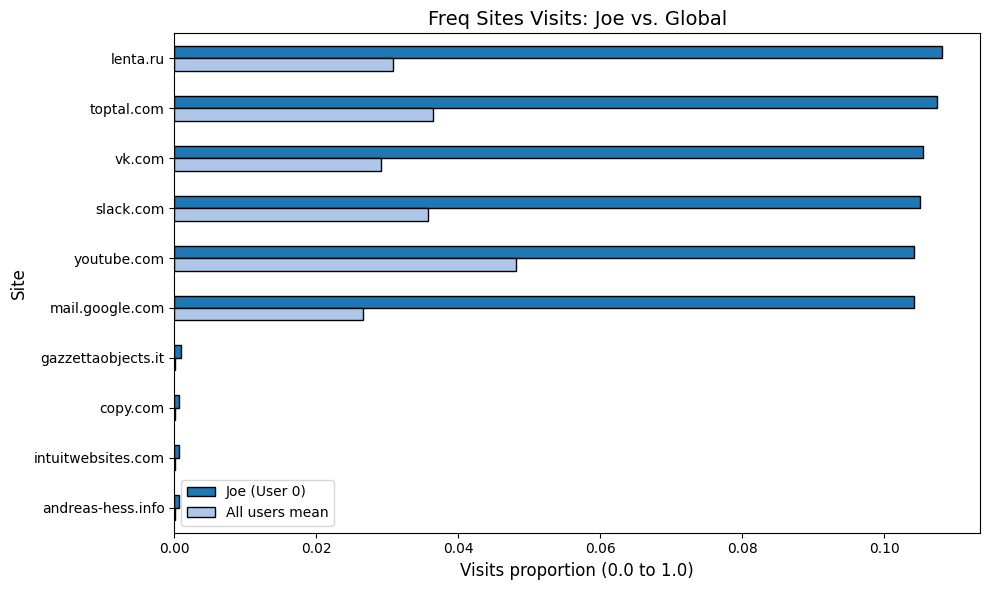

In [19]:
# Joe's site frequency vs Global users site frecuency
global_freq = df['site'].value_counts(normalize=True)
joe_id = 0
joe_freq = df[df['user_id'] == joe_id]['site'].value_counts(normalize=True)

df_comparative = pd.DataFrame({
    'Joe': joe_freq,
    'Global': global_freq
}).fillna(0).sort_values(by='Joe', ascending=False).head(10)

ax = df_comparative.plot(kind='barh', figsize=(10, 6), color=['#1f77b4', '#aec7e8'], edgecolor='black')
ax.invert_yaxis() 
ax.set_title('Freq Sites Visits: Joe vs. Global', fontsize=14)
ax.set_xlabel('Visits proportion (0.0 to 1.0)', fontsize=12)
ax.set_ylabel('Site', fontsize=12)
ax.legend(["Joe (User 0)", "All users mean"])
plt.tight_layout()
plt.show()

Observation: These are going to be the top sites (6) to be encoded for our model.

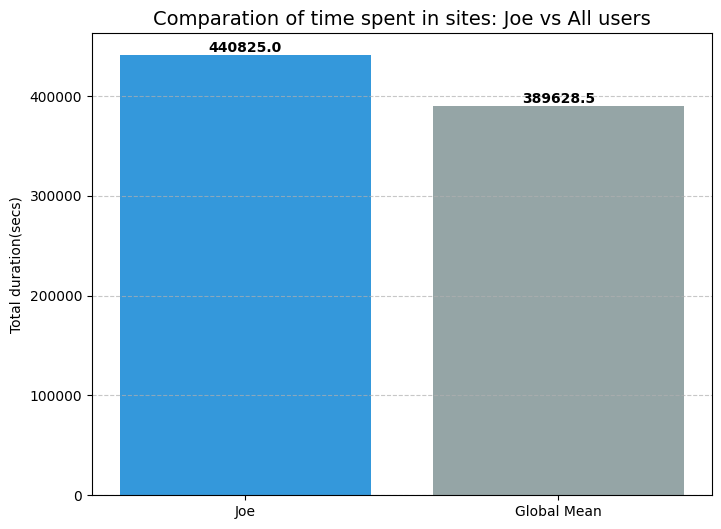

In [20]:
# Average time in sites: Joe vs All users
df_total = my_data.groupby('user_id')['total_duration'].sum().to_frame(name='total_time_per_user')
joe_id = 0
joe_time = df_total.loc[joe_id, 'total_time_per_user']
user_mean = df_total['total_time_per_user'].mean()

df_plot = pd.DataFrame({
    'Category': ['Joe', 'Global Mean'],
    'Total time': [joe_time, user_mean]
})


plt.figure(figsize=(8, 6))
colors = ['#3498db', '#95a5a6']
bars = plt.bar(df_plot['Category'], df_plot['Total time'], color=colors)
plt.title('Comparation of time spent in sites: Joe vs All users', fontsize=14)
plt.ylabel('Total duration(secs)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, round(yval, 1), ha='center', va='bottom', fontweight='bold')

plt.show()

<font size="4"> Joe's Data Analysis: </font> This will help us in defyning most relevant features and information for our model

In [21]:
joe_data = my_data[my_data["user_id"]==0]

In [22]:
joe_data.head(3)

,browser,os,locale,user_id,gender,location,time,date,total_duration,mean_duration,max_duration,num_sites,sites_str,class
77,Firefox,Windows 10,ru_RU,0,m,France/Paris,10:13:00,2016-04-30,1177,117.7,215,10,mail.google.com vk.com lenta.ru slack.com yout...,Joe
198,Chrome,Windows 10,ru_RU,0,m,USA/Chicago,18:26:00,2016-11-22,930,155.0,289,6,youtube.com vk.com infolignes.com bcbits.com n...,Joe
200,Firefox,Windows 10,ru_RU,0,m,Canada/Toronto,16:57:00,2017-08-05,648,108.0,208,6,mail.google.com vk.com toptal.com slack.com le...,Joe


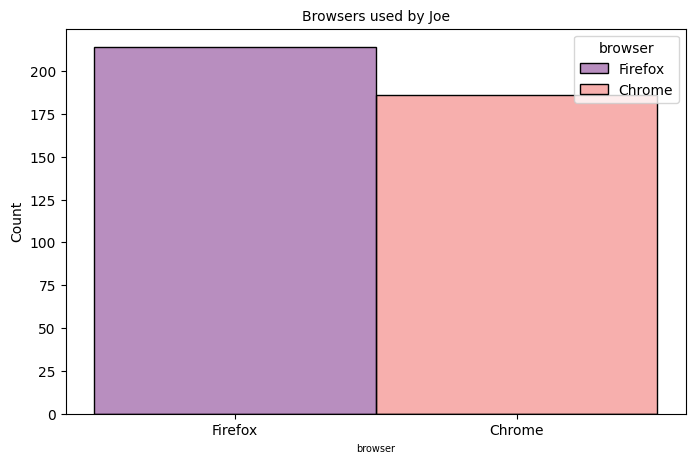

In [23]:
plt.figure(figsize=(8, 5))
sns.histplot(data = joe_data, x= "browser" , hue ="browser", palette="magma")
plt.title('Browsers used by Joe', fontsize=10)
plt.xlabel('browser', fontsize=7)
plt.show()

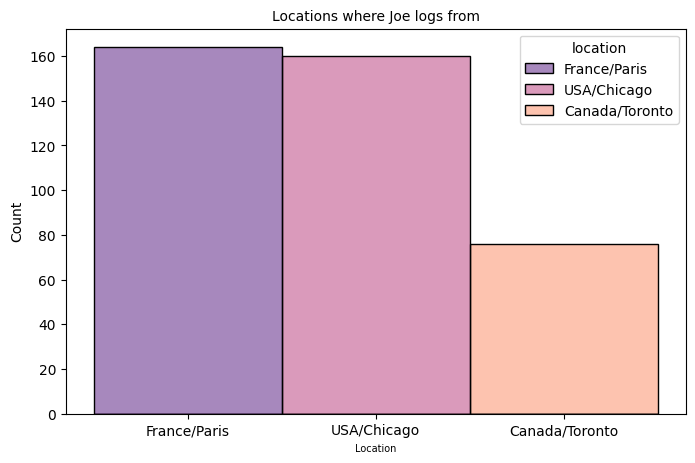

In [24]:
plt.figure(figsize=(8, 5))
sns.histplot(data = joe_data, x= "location" , hue ="location", palette="magma")
plt.title('Locations where Joe logs from', fontsize=10)
plt.xlabel('Location', fontsize=7)
plt.show()

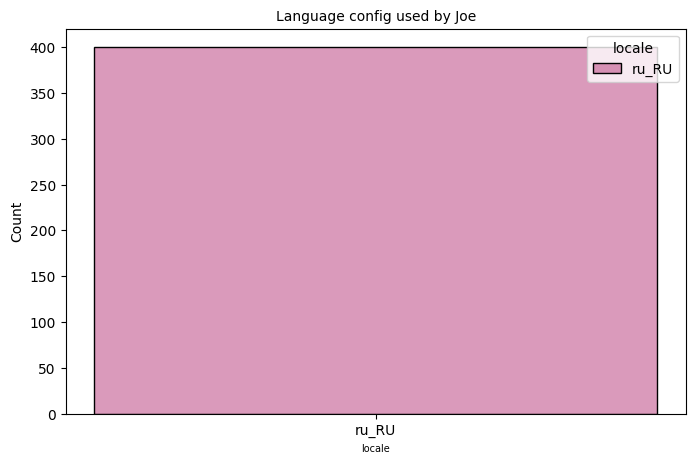

In [25]:
plt.figure(figsize=(8, 5))
sns.histplot(data = joe_data, x= "locale" , hue ="locale", palette="magma")
plt.title('Language config used by Joe', fontsize=10)
plt.xlabel('locale', fontsize=7)
plt.show()

In [26]:
# Using "df" dataframe to get additional information about Joe
more_joe = df[df["user_id"]==0]

In [27]:
more_joe

,site,length,browser,os,locale,user_id,gender,location,time,date
574,mail.google.com,86,Firefox,Windows 10,ru_RU,0,m,France/Paris,10:13:00,2016-04-30
575,vk.com,158,Firefox,Windows 10,ru_RU,0,m,France/Paris,10:13:00,2016-04-30
576,lenta.ru,215,Firefox,Windows 10,ru_RU,0,m,France/Paris,10:13:00,2016-04-30
577,slack.com,58,Firefox,Windows 10,ru_RU,0,m,France/Paris,10:13:00,2016-04-30
578,youtube.com,161,Firefox,Windows 10,ru_RU,0,m,France/Paris,10:13:00,2016-04-30
...,...,...,...,...,...,...,...,...,...,...
601219,slack.com,71,Firefox,Ubuntu,ru_RU,0,m,USA/Chicago,17:55:00,2017-03-13
601220,mail.google.com,54,Firefox,Ubuntu,ru_RU,0,m,USA/Chicago,17:55:00,2017-03-13
601221,plexop.net,88,Firefox,Ubuntu,ru_RU,0,m,USA/Chicago,17:55:00,2017-03-13
601222,galaxys5.fr,276,Firefox,Ubuntu,ru_RU,0,m,USA/Chicago,17:55:00,2017-03-13


In [28]:
most_visited = more_joe.groupby("site").size().reset_index(name="count").sort_values(by="count", ascending=False)
top_10_most_visited = most_visited.head(10)

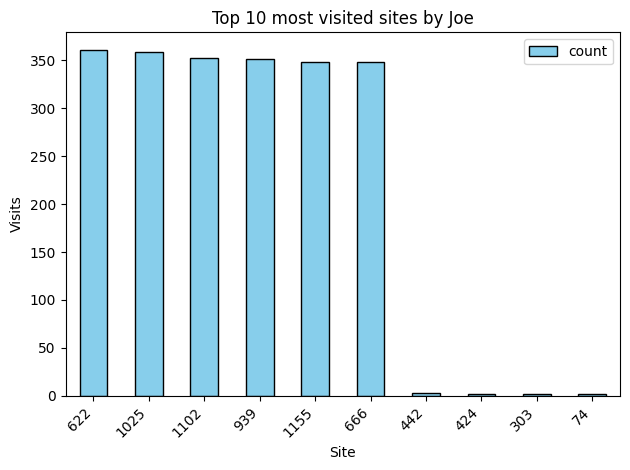

In [29]:
top_10_most_visited.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 most visited sites by Joe')
plt.xlabel('Site')
plt.ylabel('Visits')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()

Observation: These top sites are going to be useful informaition later for our prediction model

In [30]:
# Data cleaning to get more information about joe

In [31]:
joe_data['hour'] = pd.to_datetime(joe_data['time'], format='%H:%M:%S').dt.hour

C:\Users\Valentin Villanueva\AppData\Local\Temp\ipykernel_22896\2516329714.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joe_data['hour'] = pd.to_datetime(joe_data['time'], format='%H:%M:%S').dt.hour


moment_of_day
night        213
afternoon    103
morming       84
Name: count, dtype: int64


C:\Users\Valentin Villanueva\AppData\Local\Temp\ipykernel_22896\2865899386.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joe_data['moment_of_day'] = joe_data['hour'].apply(moment)


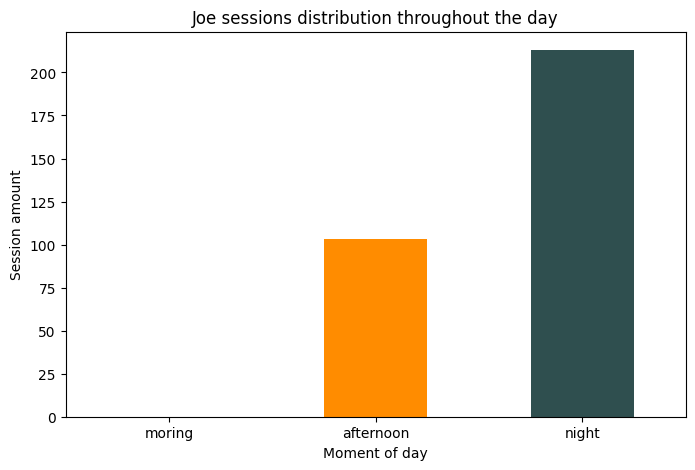

In [32]:
def moment(h):
    if 6 <= h < 12:
        return 'morming'
    elif 12 <= h < 19:
        return 'afternoon'
    else:
        return 'night'
joe_data['moment_of_day'] = joe_data['hour'].apply(moment)
counting = joe_data['moment_of_day'].value_counts()
print(counting)

order = ['moring', 'afternoon', 'night']
counting = counting.reindex(order)

counting.plot(kind='bar', color=['#FFD700', '#FF8C00', '#2F4F4F'], figsize=(8, 5))
plt.title('Joe sessions distribution throughout the day')
plt.ylabel('Session amount')
plt.xlabel('Moment of day')
plt.xticks(rotation=0)
plt.show()

Observation: Joe mostly has night sessions, this is very useful information!